In [1]:
import pandas as pd
import seaborn as sns
import pylab as plt
import nibabel as nb
import numpy as np
import os
from nilearn.image import resample_img, smooth_img
from nilearn.plotting import plot_glass_brain, plot_stat_map
from scipy import stats
import joblib
%matplotlib inline

/opt/conda/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
df = pd.read_csv("/data/smoothness_and_volume.csv", index_col=0)

In [3]:
import numpy as np

def hist_match(source, t_quantiles, t_values):
    """
    Adjust the pixel values of a grayscale image such that its histogram
    matches that of a target image

    Arguments:
    -----------
        source: np.ndarray
            Image to transform; the histogram is computed over the flattened
            array
        template: np.ndarray
            Template image; can have different dimensions to source
    Returns:
    -----------
        matched: np.ndarray
            The transformed output image
    """

    oldshape = source.shape
    source = source.ravel()

    # get the set of unique pixel values and their corresponding indices and
    # counts
    s_values, bin_idx, s_counts = np.unique(source, return_inverse=True,
                                            return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    s_quantiles = np.cumsum(s_counts).astype(np.float64)
    s_quantiles /= s_quantiles[-1]
    
    # interpolate linearly to find the pixel values in the template image
    # that correspond most closely to the quantiles in the source image
    interp_t_values = np.interp(s_quantiles, t_quantiles, t_values)

    return interp_t_values[bin_idx].reshape(oldshape)

In [4]:
def save_fake_map(orig_inside_mask, map_nii, row, mask_nii, t_quantiles, t_values, i, j):
    np.random.seed(j)
    new_data = np.random.choice(orig_inside_mask, size=map_nii.shape, replace=True)

    shuffled_nii = nb.Nifti1Image(new_data, map_nii.affine, map_nii.header)
    smoothed_nii = smooth_img(shuffled_nii, np.array([row.FWHMx_mm, row.FWHMy_mm, row.FWHMz_mm]))
    new_data = smoothed_nii.get_data()
    new_data[mask_nii.get_data() != 1] = np.nan
    new_inside_mask = stats.zscore(new_data[mask_nii.get_data() == 1])

    new_data[mask_nii.get_data() == 1] = new_inside_mask #hist_match(new_inside_mask, t_quantiles, t_values)

    masked_nii = nb.Nifti1Image(new_data, map_nii.affine, map_nii.header)
        
    masked_nii.to_filename("/data/images/fake_maps/%04d/%04d.nii.gz"%(i, j))

In [5]:
!mkdir -p /data/images/fake_maps

for i,row in df.iterrows():
    print "generating fake data for map images/resampled/%04d.nii.gz"%i
    map_nii = nb.load("/data/images/resampled/%04d.nii.gz"%i)
    mask_nii = nb.load("/data/images/resampled_masks/%04d.nii.gz"%i)
    
    orig_inside_mask = map_nii.get_data()[mask_nii.get_data() == 1]
    
    folder_name = "%04d"%i
    if os.path.exists("/data/images/fake_maps/%04d/"%(i)):
        continue
    !mkdir -p /data/images/fake_maps/{"%04d"%i}
    
    template = orig_inside_mask.ravel()
    
    t_values, t_counts = np.unique(template, return_counts=True)

    # take the cumsum of the counts and normalize by the number of pixels to
    # get the empirical cumulative distribution functions for the source and
    # template images (maps pixel value --> quantile)
    t_quantiles = np.cumsum(t_counts).astype(np.float64)
    t_quantiles /= t_quantiles[-1]
    
    from joblib import Parallel, delayed
    Parallel(n_jobs=4)(delayed(save_fake_map)(orig_inside_mask, map_nii, row, mask_nii, t_quantiles, t_values, i, j) for j in range(200))
    

generating fake data for map images/resampled/0003.nii.gz
generating fake data for map images/resampled/0004.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0005.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0056.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0057.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0058.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0106.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0109.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0110.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0111.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0112.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0113.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0115.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0116.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0117.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0118.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0119.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0120.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0121.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0122.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0123.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0124.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0125.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0126.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0127.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0130.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0131.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0132.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0135.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


generating fake data for map images/resampled/0136.nii.gz


/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':
/opt/conda/envs/python2/lib/python2.7/site-packages/nilearn/image/image.py:201: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if fwhm == 'fast':


KeyboardInterrupt: 

In [144]:
filenames = !ls images/fake_maps/0003/*.nii.gz

image_ids = []
FWHMx_mms = []
FWHMy_mms = []
FWHMz_mms = []
volume_voxs = []

for fname in filenames:
    image_id = fname.split("/")[-1][:-7]
    output = !smoothest -z {fname} -m images/resampled_masks/0003.nii.gz -V
    FWHMx_mm, FWHMy_mm, FWHMz_mm = [float(val[len("FWHMx = "):-3])  for val in output[-7].split(", ")]
    volume_vox = output[-2].split()[1]
    image_ids.append(image_id)
    FWHMx_mms.append(FWHMx_mm)
    FWHMy_mms.append(FWHMy_mm)
    FWHMz_mms.append(FWHMz_mm)
    volume_voxs.append(volume_vox)

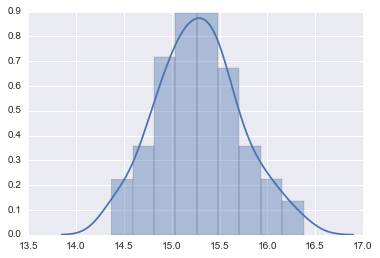

In [146]:
sns.distplot(FWHMx_mms)

In [150]:
row.FWHMx_mm, row.FWHMy_mm, row.FWHMz_mm

(15.604200000000001, 16.566099999999999, 16.220300000000002)

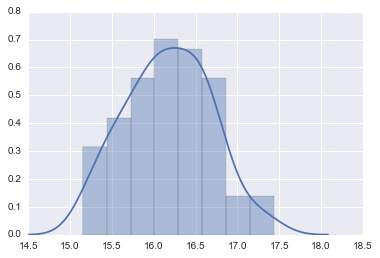

In [148]:
sns.distplot(FWHMy_mms)

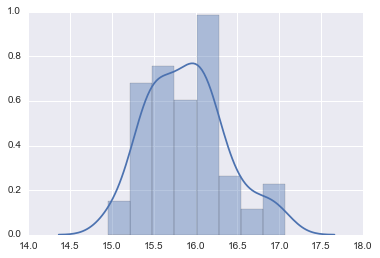

In [149]:
sns.distplot(FWHMz_mms)

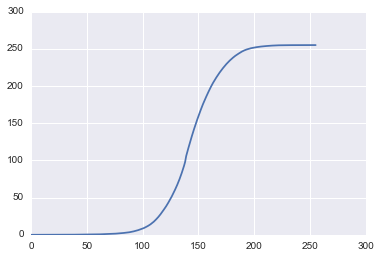

In [80]:
plt.plot(cdf_orig)

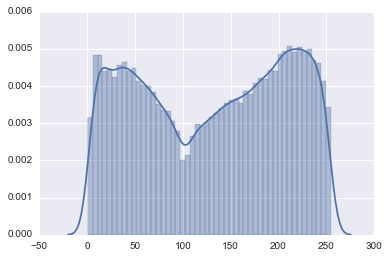

In [101]:
sns.distplot(im2)

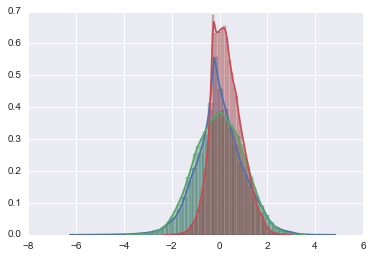

In [113]:
nbr_bins = 256
imhist_orig, bins_orig = np.histogram(orig_inside_mask,nbr_bins,normed=True)
cdf_orig = imhist_orig.cumsum() #cumulative distribution function
cdf_orig = 255 * cdf_orig / cdf_orig[-1] #normalize

imhist_new, bins_new = np.histogram(new_inside_mask,nbr_bins,normed=True)
cdf_new = imhist_new.cumsum() #cumulative distribution function
cdf_new = 255 * cdf_new / cdf_new[-1] #normalize

im2 = np.interp(new_inside_mask, bins_orig[:-1], cdf_new)
im3 = np.interp(im2, cdf_orig, bins_orig[:-1])

sns.distplot(orig_inside_mask)
sns.distplot(new_inside_mask)
sns.distplot(im3)

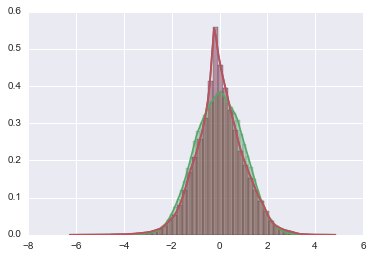

In [117]:
sns.distplot(orig_inside_mask)
sns.distplot(new_inside_mask)
sns.distplot(hist_match(new_inside_mask, orig_inside_mask))

In [128]:
!fslview /tmp/fake_data.nii.gz

In [129]:
!ls -alh /tmp/fake_data.nii.gz

-rw-r--r--  1 filo  wheel   873K Jan  4 11:21 /tmp/fake_data.nii.gz


In [131]:
np.savez("/tmp/fake.pklz", new_inside_mask)

In [132]:
!ls -alh /tmp/fake.pklz.npz

-rw-r--r--  1 filo  wheel   893K Jan  4 11:36 /tmp/fake.pklz.npz


In [27]:
df[df.index == 564]

,FWHMx_mm,FWHMy_mm,FWHMz_mm,volume_vox
564,19.3934,20.3302,15.624,190626
